# Session-based travel recommendations
> Experimenting with 8 ML models on a simple Trivago-inspired session-based travel dataset

- toc: true
- badges: true
- comments: true
- categories: [Logistic, LightGBM, KNN, Session, Sequence, Trivago, Travel]
- image:

## Problem statement

### Context

Recommending hotels and other travel-related items is still a difficult task, as travel and tourism is a very complex domain. Planning a trip usually involves searching for a set or package of products that are interconnected (e.g., means of transportation, lodging, attractions), with rather limited availability, and where contextual aspects may have a major impact (e.g., time, location, social context). Users book much fewer hotels than, for example, listen to music tracks, and, given the financial obligation of booking a stay at a hotel, users usually exhibit a strong price sensitivity and a bigger need to be convinced by any given offer. Besides, travelers are often emotionally connected to the products and the experience they provide. Therefore, decision making is not only based on rational and objective criteria. As such, providing the right information to visitors to a travel site, such as a hotel booking service, at the right time is challenging. Information about items such as hotels is often available as item metadata. However, usually, in this domain information about users and their goals and preferences is harder to obtain. Systems need to analyze session-based data of anonymous or first-time users to adapt the search results and anticipate the hotels the users may be interested in.

Trivago is a global hotel search platform focused on reshaping the way travelers search for and compare hotels, while enabling advertisers of hotels to grow their businesses by providing access to a broad audience of travelers via their websites and apps. Trivago provide aggregated information about the characteristics of each accommodation to help travelers to make an informed decision and find their ideal place to stay. Once a choice is made, the users get redirected to the selected booking site to complete the booking. Trivago has established 55 localized platforms in over 190 countries and provides access to over two million hotels, including alternative accommodations, with prices and availability from over 400+ booking sites and hotel chains. 

Our users can narrow down their search by selecting filters and specifying the desired characteristics of their preferred accommodation. They can interact with the different offers presented to them and consume the aggregated information for each listing to make an informed decision and find their ideal place to stay. Once a choice is made, the users get redirected to the selected booking site to complete the booking. It is in the interest of all participants (traveler, advertising booking site, and trivago) to suggest suitable accommodations that fit the needs of the traveler.

> *We partnered with researchers from TU Wien, Politecnico di Milano, and Karlsruhe Institute of Technology to launch the RecSys Challenge 2019, the annual data science challenge of the ACM Recommender Systems conference. In this challenge, we invite participants to dig deep into our data and come up with creative ideas to detect the intent of our users and build a click-prediction model that can be used to update the recommendation of accommodations. To this end, we have released a data set of user interactions on our website.*

### Challenges

Trivago face a few challenges when it comes to recommending the best options for their visitors, so it’s important to effectively make use of the explicit and implicit user signals within a session (clicks, search refinement, filter usage) to detect the users’ intent as quickly as possible and to update the recommendations to tailor the result list to these needs.

Due to the nature of our domain, we face specific challenges that make it difficult to build predictive models and recommendation systems that are tailored to the needs of our visitors. Here are a few examples of the problems that trivago data scientists have to address:

- Users search for accommodations comparatively infrequently with sometimes long time intervals between their trips. Furthermore, user intent and preferences change over time and depend on the purpose of the trip (e.g. a business traveler who books accommodation for a weekend trip with her family).
- Booking accommodation is an expensive transaction. Visitors are price sensitive and careful when they make a decision. As the availability of the accommodations, the search criteria, and the actual pricing of the deals from the advertisers vary over time, the context­ of each search has to be taken into consideration.
- Information about the personal preferences of travelers is sparse. The service provided to our users is free of charge ─ users do not have to provide personal data or make an account in order to use the website.

### Goal

The task of the challenge is to use all the information about the behavioral, time-dependent patterns of the users and the content of the displayed accommodations to develop models that allow to predict which accommodations a user is most likely to click on when presented with a list of potential options.

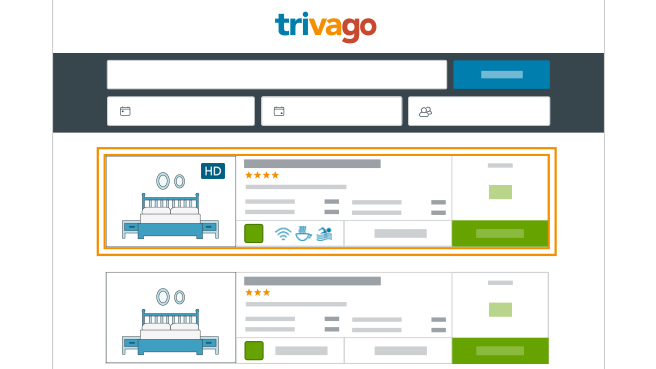

### Illustration

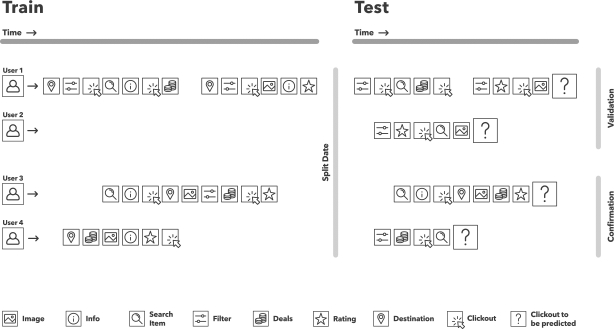

Schematic illustration of the dataset and how it is split between train and test set. Each icon in the schematic represents a different type of website interaction, such as clicking on item content (image, info, rating, deals), refining the search parameters via filtering, or triggering new searches for accommodations (items) or destinations. All interactions can be performed by the users and are indicated by the icons in the schematic. Gaps between consecutive interactions indicate the start of a new user session. The train set contains sessions before November 7, 2018, while the test set contains sessions after said date. The item_id of the final click out (shown as the box with the question marks) has been withheld. Note that the question mark refers only to the accommodation identifier that needs to be predicted and not the action type and that every event for which a prediction needs to be made is a click-out. For the evaluation of the leaderboard, the test set has been split into confirmation and a validation set on a user basis.

## Data description

Trivago provided two sets of data, the user-item interaction and the item metadata. The interaction dataset consists of the sequential website interactions of users visiting the trivago website between November 1, 2018, and November 8, 2018. Each website interaction corresponds to a specific timestamp in the dataset. Multiple website interactions can appear in a user session. A session is defined as all interactions of a user on a specific trivago country platform with no gaps between the interaction timestamps of >60 minutes. If a user stops interacting with the website and returns after a couple of minutes to continue the search, then the continued interactions will still be counted to belong to the same session. Because of the grouping of website interactions into sessions, the interactions are in the following often referred to as session actions. For each session interaction, data about the context of the interaction are provided, e.g., the country platform on which the interaction took place or the list of items that were shown at the moment of a click and the prices of the accommodations.

### Description of Action Types and Reference Values for All Possible Session Interactions

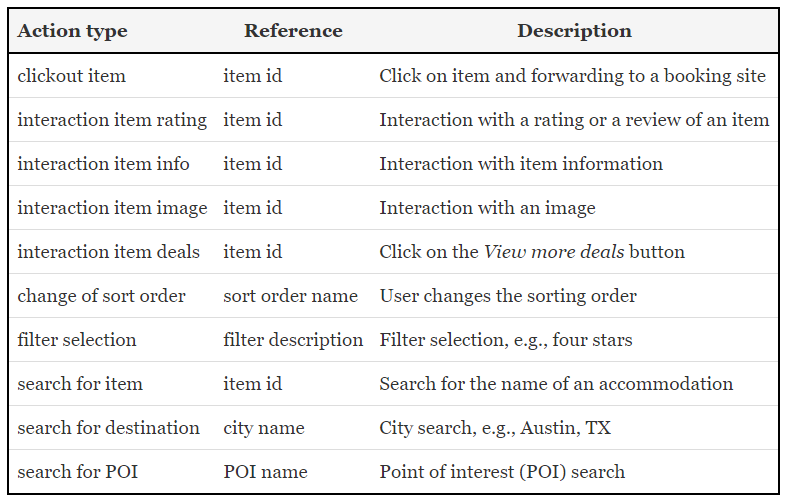

Each website interaction corresponds to a specific timestamp in the dataset. Multiple website interactions can appear in a user session. A session is defined as all interactions of a user on a specific trivago country platform with no gaps between the interaction timestamps of >60 minutes. If a user stops interacting with the website and returns after a couple of minutes to continue the search, then the continued interactions will still be counted to belong to the same session. Because of the grouping of website interactions into sessions, the interactions are in the following often referred to as session actions. For each session interaction, data about the context of the interaction are provided, e.g., the country platform on which the interaction took place or the list of items that were shown at the moment of a click and the prices of the accommodations. Metadata for each of the accommodations are provided in a separate file.

### General Statistics of the RecSys Challenge 2019 Dataset

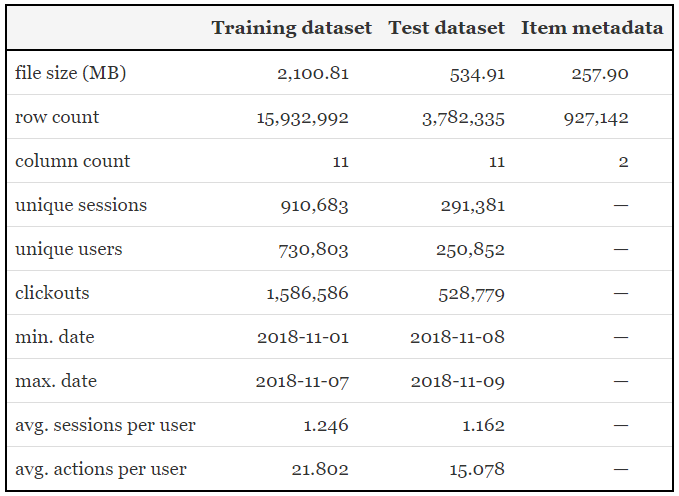

### Session Actions Files

Each row in the session action files (train.csv and test.csv) corresponds to a particular user action in a given session. The schema of these files is shown in the below table. The split between the train and test sets was done at a particular split date. That is, sessions that occurred before November 7, 2018, were put into the train set, while those that occurred after were put into the test set. The target of the test set is items clicked out at the end of the sessions in the test set.

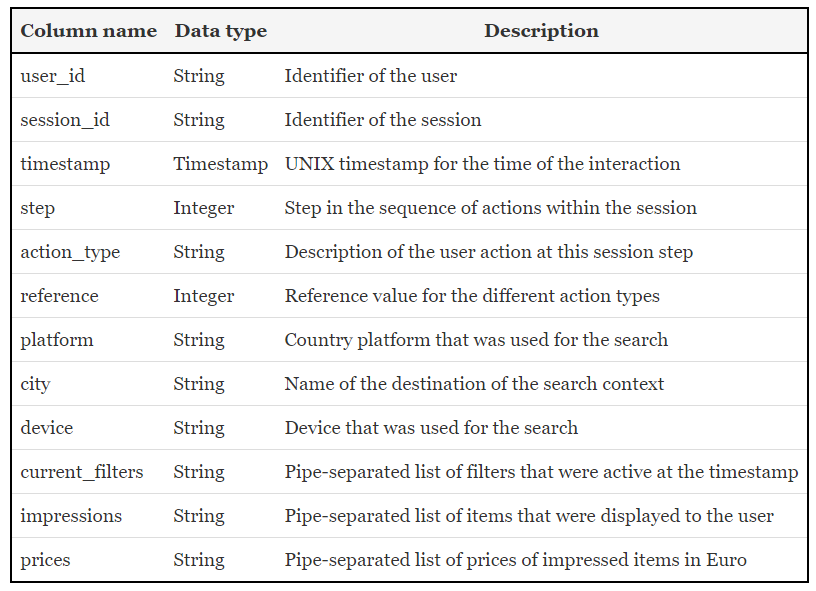

In addition to the user actions, the train.csv and test.csv files also contain information about the accommodations that were displayed to the user at the time a clickout was made. An accommodation that is displayed is referred to as being “impressed” and all displayed accommodations are stored in the “impressions” column. Each row in that column is a list of accommodations (items) in the order in which they were displayed on the website. In case the user action was not a clickout, the impressions column is left empty.

## Setup

In [ ]:
!pip install -q git+https://github.com/sparsh-ai/recochef.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import time
import math
import random
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from recochef.datasets.trivago import Trivago
from recochef.datasets.synthetic import Session

## Data loading

### Full load

In [ ]:
trivago = Trivago()

In [ ]:
df_train = trivago.load_train()
df_train.head()

,USERID,SESSIONID,TIMESTAMP,STEP,EVENTTYPE,REFERENCE,PLATFORM,CITY,DEVICE,FILTERS,IMPRESSIONS,PRICES
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,None,None,None
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,None,None,None
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,None,None,None
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,None,None,None
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,None,None,None


In [ ]:
df_test = trivago.load_test()
df_test.head()

,USERID,SESSIONID,TIMESTAMP,STEP,EVENTTYPE,REFERENCE,PLATFORM,CITY,DEVICE,FILTERS,IMPRESSIONS,PRICES
0,004A07DM0IDW,1d688ec168932,1541555614,1,interaction item image,2059240,CO,"Santa Marta, Colombia",mobile,None,None,None
1,004A07DM0IDW,1d688ec168932,1541555614,2,interaction item image,2059240,CO,"Santa Marta, Colombia",mobile,None,None,None
2,004A07DM0IDW,1d688ec168932,1541555696,3,clickout item,1050068,CO,"Santa Marta, Colombia",mobile,None,2059240|2033381|1724779|127131|399441|103357|1...,70|46|48|76|65|65|106|66|87|43|52|44|60|61|50|...
3,004A07DM0IDW,1d688ec168932,1541555707,4,clickout item,1050068,CO,"Santa Marta, Colombia",mobile,None,2059240|2033381|1724779|127131|399441|103357|1...,70|46|48|76|65|65|106|66|87|43|52|44|60|61|50|...
4,004A07DM0IDW,1d688ec168932,1541555717,5,clickout item,1050068,CO,"Santa Marta, Colombia",mobile,None,2059240|2033381|1724779|127131|399441|103357|1...,70|46|48|76|65|65|106|66|87|43|52|44|60|61|50|...


### Sample load

In [ ]:
sample_session_data = Session(version='trivago')

In [ ]:
df_train = sample_session_data.train()
df_train

,user_id,session_id,timestamp,step,action_type,reference,impressions,prices
0,64BL89,3579f89,1,1,interaction item image,5001,NaN,NaN
1,64BL89,3579f89,2,2,clickout item,5002,5014|5002|5010,100|125|120
2,64BL89,3579f89,3,3,interaction item info,5003,NaN,NaN
3,64BL89,3579f89,4,4,filter selection,unknown,NaN,NaN
4,64BLF,4504h9,2,1,interaction item image,5010,NaN,NaN
5,64BLF,4504h9,4,2,clickout item,5001,5001|5023|5040|5005,75|110|65|210
6,64BL89,5504hFL,7,1,filter selection,unknown,NaN,NaN
7,64BL89,5504hFL,8,2,clickout item,5004,5010|5001|5023|5004|5002|5008,120|89|140|126|86|110
8,64BL89,5504hFL,9,3,interaction item image,5001,NaN,NaN
9,64BL89,5504hFL,10,4,clickout item,5001,5010|5001|5023|5004|5002|5008,120|89|140|126|86|110


1. User ```64BL89``` viewed the image of item 5001.
2. User ```64BL89``` clicked on item 5002. 3 items (5014, 5002, 5010) were shown to the user and user clicked on 2nd item which is 5002. It was the costliest among the 3 items.
3. User ```64BL89``` viewed more info of item 5003.
4. User ```64BL89``` selected an unknown filter.
5. User ```64BLF``` viewed image of item 5010.
6. User ```64BLF``` clicked item 5001. It was on top of the recommended list.
7. User ```64BL89``` again came back after some time. A new session started for this user. User directly started with applying unknown filter.
8. User ```64BL89``` clicked on item 5004. It was at 4th position.
9. User ```64BL89``` again viewed the image of item 5001.
10. User ```64BL89``` now clicked item 5001 this time. It was at 2nd position.


In [ ]:
df_test = sample_session_data.test()
df_test

,user_id,session_id,timestamp,step,action_type,reference,impressions,prices
0,64BL89,3579f90,5,1,interaction item image,5023,NaN,NaN
1,64BL89,3579f90,6,2,clickout item,NaN,5002|5003|5010|5004|5001|5023,120|75|110|105|89|99
2,64BL91F2,3779f92,9,1,interaction item info,5010,NaN,NaN
3,64BL91F2,3779f92,10,2,clickout item,NaN,5001|5004|5010|5014,76|102|115|124
4,64BL91F2,3779f92,11,3,filter selection,unknown,NaN,NaN


In [ ]:
df_items = sample_session_data.items()
df_items

,item_id,properties
0,5001,Wifi|Croissant|TV
1,5002,Wifi|TV
2,5003,Croissant
3,5004,Shoe dryer


## Utilities

In [ ]:
def explode(df, col_expl):
    """Separate string in column col_expl and explode elements into multiple rows."""

    s = df[col_expl].str.split('|', expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2[col_expl] = s.values

    return df2


def explode_mult(df_in, col_list):
    """Explode each column in col_list into multiple rows."""

    df = df_in.copy()

    for col in col_list:
        df.loc[:, col] = df.loc[:, col].str.split("|")

    df_out = pd.DataFrame(
        {col: np.repeat(df[col].to_numpy(),
                        df[col_list[0]].str.len())
         for col in df.columns.drop(col_list)}
    )

    for col in col_list:
        df_out.loc[:, col] = np.concatenate(df.loc[:, col].to_numpy())

    return df_out


def group_concat(df, gr_cols, col_concat):
    """Concatenate multiple rows into one."""

    df_out = (
        df
        .groupby(gr_cols)[col_concat]
        .apply(lambda x: ' '.join(x))
        .to_frame()
        .reset_index()
    )

    return df_out


def get_target_rows(df):
    """Restrict data frame to rows for which a prediction needs to be made."""
    
    df_target = df[
        (df.action_type == "clickout item") & 
        (df["reference"].isna())
    ]

    return df_target


def summarize_recs(df, rec_col):
    """Bring the data frame into submission format."""

    df_rec = (
        df
        .sort_values(by=["user_id", "session_id", "timestamp", "step", rec_col],
                        ascending=[True, True, True, True, False])
        .groupby(["user_id", "session_id", "timestamp", "step"])["impressed_item"]
        .apply(lambda x: ' '.join(x))
        .to_frame()
        .reset_index()
        .rename(columns={'impressed_item': 'item_recommendations'})
    )

    return df_rec

In [ ]:
def print_time(s):
    """Print string s and current time."""

    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    print(f"{current_time} | {s}")


def print_header(s):
    """Print a nice header for string s."""

    print()
    print(f"##{'#'*len(s)}##")
    print(f"# {s} #")
    print(f"##{'#'*len(s)}##")
    print()


def validate_model_name(model_name):
    """Check if the inserted model name is valid."""

    model_names = [
        'gbm_rank', 'logistic_regression',
        'nn_interaction', 'nn_item',
        'pop_abs', 'pop_user', 
        'position', 'random'
    ]

    try:
        if model_name not in model_names: raise NameError
    except NameError:
        print("No such model. Please choose a valid one.")
        sys.exit(1)

## Feature engineering

In [64]:
def build_features(df):
    """Build features for the lightGBM and logistic regression model."""

    # Select columns that are of interest for this method
    print_time("start")
    cols = ['user_id', 'session_id', 'timestamp', 'step',
            'action_type', 'reference', 'impressions', 'prices']
    df_cols = df.loc[:, cols] 

    # We are only interested in action types, for wich the reference is an item ID
    print_time("filter interactions")
    item_interactions = [
        'clickout item', 'interaction item deals', 'interaction item image',
        'interaction item info', 'interaction item rating', 'search for item'
    ]
    df_actions = (
        df_cols
        .loc[df_cols.action_type.isin(item_interactions), :]
        .copy()
        .rename(columns={'reference': 'referenced_item'})
    )

    print_time("cleaning")
    # Clean of instances that have no reference
    idx_rm = (df_actions.action_type != "clickout item") & (df_actions.referenced_item.isna())
    df_actions = df_actions[~idx_rm]

    # Get item ID of previous interaction of a user in a session
    print_time("previous interactions")
    df_actions.loc[:, "previous_item"] = (
        df_actions
        .sort_values(by=["user_id", "session_id", "timestamp", "step"],
                        ascending=[True, True, True, True])
        .groupby(["user_id"])["referenced_item"]
        .shift(1)
    )

    # Combine the impressions and item column, they both contain item IDs
    # and we can expand the impression lists in the next step to get the total
    # interaction count for an item
    print_time("combining columns - impressions")
    df_actions.loc[:, "interacted_item"] = np.where(
        df_actions.impressions.isna(),
        df_actions.referenced_item,
        df_actions.impressions
    )
    df_actions = df_actions.drop(columns="impressions")

    # Price array expansion will get easier without NAs
    print_time("combining columns - prices")
    df_actions.loc[:, "prices"] = np.where(
        df_actions.prices.isna(),
        "",
        df_actions.prices
    )

    # Convert pipe separated lists into columns
    print_time("explode arrays")
    df_items = explode_mult(df_actions, ["interacted_item", "prices"]).copy()

    # Feature: Number of previous interactions with an item
    print_time("interaction count")
    df_items.loc[:, "interaction_count"] = (
        df_items
        .groupby(["user_id", "interacted_item"])
        .cumcount()
    )

    # Reduce to impression level again 
    print_time("reduce to impressions")
    df_impressions = (
        df_items[df_items.action_type == "clickout item"]
        .copy()
        .drop(columns="action_type")
        .rename(columns={"interacted_item": "impressed_item"})
    )

    # Feature: Position of item in the original list.
    # Items are in original order after the explode for each index
    print_time("position feature")
    df_impressions.loc[:, "position"] = (
        df_impressions
        .groupby(["user_id", "session_id", "timestamp", "step"])
        .cumcount()+1
    )

    # Feature: Is the impressed item the last interacted item
    print_time("last interacted item feature")
    df_impressions.loc[:, "is_last_interacted"] = (
        df_impressions["previous_item"] == df_impressions["impressed_item"]
    ).astype(int)

    print_time("change price datatype")
    df_impressions.loc[:, "prices"] = df_impressions.prices.astype(int)

    return_cols = [
        "user_id",
        "session_id",
        "timestamp",
        "step",
        "position",
        "prices",
        "interaction_count",
        "is_last_interacted",
        "referenced_item",
        "impressed_item",
    ]

    df_return = df_impressions[return_cols]

    return df_return

## Models

### List of models
    - gbm_rank: lightGBM model
    - log_reg: Logistic regression
    - nn_interaction: kNN w/ session co-occurrence
    - nn_item: kNN w/ metadata similarity
    - pop_abs: Popularity - total clicks
    - pop_user: Popularity - distinct users
    - position: Original display position
    - random: Random order

### random

In [ ]:
#collapse-hide
class ModelRandom():
    """
    Model class for the random ordering model.
    Methods
        fit(df): Not needed. Only added for consistency with other model classes
        predict(df): Calculate recommendations for test data        
    """
    def fit(self, _):
        pass


    def predict(self, df):
        """Randomly sort the impressions list."""

        # Target row, withheld item ID that needs to be predicted
        print_time("target rows")
        df_target = get_target_rows(df.copy())

        # Summarize recommendations
        print_time("summarize recommendations")
        random.seed(10121)
        df_target.loc[:, "item_recs_list"] = (
            df_target
            .loc[:, "impressions"].str.split("|")
            .map(lambda x: sorted(x, key=lambda k: random.random()))
        )

        df_target.loc[:, "item_recommendations"] = (
           df_target["item_recs_list"]
           .map(lambda arr: ' '.join(arr))
        )

        cols_rec = ["user_id", "session_id", "timestamp", "step", "item_recommendations"]
        df_rec = df_target.loc[:, cols_rec]

        return df_rec

In [ ]:
model = ModelRandom()
model.fit(df_train)
df_recommendations = model.predict(df_test)

14:47:52 | target rows
14:47:52 | summarize recommendations


In [ ]:
df_recommendations

,user_id,session_id,timestamp,step,item_recommendations
1,64BL89,3579f90,6,2,5004 5010 5001 5002 5003 5023
3,64BL91F2,3779f92,10,2,5001 5010 5014 5004


### position

In [ ]:
#collapse-hide
class ModelPosition():
    """
    Model class for the model based on the original position in displayed list.
    Methods
        fit(df): Not needed. Only added for consistency with other model classes
        predict(df): Calculate recommendations for test data        
    """
    def fit(self, _):
        pass


    def predict(self, df):
        """Return items in impressions list in original order."""

        # Target row, withheld item ID that needs to be predicted
        print_time("target rows")
        df_target = get_target_rows(df.copy())

        # Summarize recommendations
        print_time("summarize recommendations")
        df_target["item_recommendations"] = (
            df_target
            .apply(lambda x: x.impressions.replace("|", " "), axis=1)
        )

        cols_rec = ["user_id", "session_id", "timestamp", "step", "item_recommendations"]
        df_rec = df_target.loc[:, cols_rec]

        return df_rec

In [ ]:
model = ModelPosition()
model.fit(df_train)
df_recommendations = model.predict(df_test)

14:51:15 | target rows
14:51:15 | summarize recommendations


In [ ]:
df_recommendations

,user_id,session_id,timestamp,step,item_recommendations
1,64BL89,3579f90,6,2,5002 5003 5010 5004 5001 5023
3,64BL91F2,3779f92,10,2,5001 5004 5010 5014


### pop_abs

In [ ]:
#collapse-hide
class ModelPopAbs():
    """
    Model class for the popularity model based on total number of clicks.
    Methods
        fit(df): Fit the model on training data
        predict(df): Calculate recommendations for test data        
    """

    def fit(self, df):
        """Count the number of clicks for each item."""

        # Select columns that are of interest for this method
        print_time("start")
        cols = ['user_id', 'session_id', 'timestamp', 'step',
                'action_type', 'reference']
        df_cols = df.loc[:, cols] 

        # We only need to count clickouts per item
        print_time("clicks per item")
        df_item_clicks = (
            df_cols
            .loc[df_cols["action_type"] == "clickout item", :]
            .groupby("reference")
            .size()
            .reset_index(name="n_clicks")
            .rename(columns={"reference": "item"})
        )

        self.df_pop = df_item_clicks


    def predict(self, df):
        """Sort the impression list by number of clicks in the training phase."""

        # Select columns that are of interest for this method
        print_time("start")
        cols = ['user_id', 'session_id', 'timestamp', 'step',
                'action_type', 'reference', "impressions"]
        df_cols = df.loc[:, cols] 

        # Target row, withheld item ID that needs to be predicted
        print_time("target rows")
        df_target = get_target_rows(df_cols)

        # Explode to impression level
        print_time("explode impression array")
        df_impressions = (
            explode(df_target, "impressions")
            .rename(columns={"impressions": "impressed_item"})
        )
        df_impressions = (
            df_impressions
            .merge(
                self.df_pop,
                left_on="impressed_item",
                right_on="item",
                how="left"
            )
        )

        # Summarize recommendations
        print_time("summarize recommendations")
        df_rec = summarize_recs(df_impressions, "n_clicks")

        return df_rec

In [ ]:
model = ModelPopAbs()
model.fit(df_train)
df_recommendations = model.predict(df_test)

14:57:30 | start
14:57:30 | clicks per item
14:57:30 | start
14:57:30 | target rows
14:57:30 | explode impression array
14:57:30 | summarize recommendations


In [ ]:
df_recommendations

,user_id,session_id,timestamp,step,item_recommendations
0,64BL89,3579f90,6,2,5001 5002 5004 5003 5010 5023
1,64BL91F2,3779f92,10,2,5001 5004 5010 5014


### pop_user

In [ ]:
#collapse-hide
class ModelPopUsers():
    """
    Model class for the popularity model based on distinct users.
    Methods
        fit(df): Fit the model on training data
        predict(df): Calculate recommendations for test data        
    """

    def fit(self, df):
        """Count the number of distinct users that click on an item."""

        # Select columns that are of interest for this method
        print_time("start")
        cols = ['user_id', 'session_id', 'timestamp', 'step',
                'action_type', 'reference']
        df_cols = df.loc[:, cols] 

        # We only need to count clickouts per item
        print_time("clicks per item")
        df_item_clicks = (
            df_cols
            .loc[df_cols["action_type"] == "clickout item", :]
            .groupby("reference")
            .user_id
            .nunique()
            .reset_index(name="n_users")
            .rename(columns={"reference": "item"})
        )

        self.df_pop = df_item_clicks


    def predict(self, df):
        """Sort the impression list by number of distinct users in the training phase."""

        # Select columns that are of interest for this method
        print_time("start")
        cols = ['user_id', 'session_id', 'timestamp', 'step',
                'action_type', 'reference', "impressions"]
        df_cols = df.loc[:, cols] 

        # Target row, withheld item ID that needs to be predicted
        print_time("target rows")
        df_target = get_target_rows(df_cols)

        # Explode to impression level
        print_time("explode impression array")
        df_impressions = (
            explode(df_target, "impressions")
            .rename(columns={"impressions": "impressed_item"})
        )
        df_impressions = (
            df_impressions
            .merge(
                self.df_pop,
                left_on="impressed_item",
                right_on="item",
                how="left"
            )
        )

        # Summarize recommendations
        print_time("summarize recommendations")
        df_rec = summarize_recs(df_impressions, "n_users")

        return df_rec

In [ ]:
model = ModelPopUsers()
model.fit(df_train)
df_recommendations = model.predict(df_test)

14:59:09 | start
14:59:09 | clicks per item
14:59:09 | start
14:59:09 | target rows
14:59:09 | explode impression array
14:59:09 | summarize recommendations


In [ ]:
df_recommendations

,user_id,session_id,timestamp,step,item_recommendations
0,64BL89,3579f90,6,2,5001 5002 5004 5003 5010 5023
1,64BL91F2,3779f92,10,2,5001 5004 5010 5014


### nn_item

In [ ]:
#collapse-hide
def calc_item_sims(df, item_col, reference_col):
    """Calculate similarity of items based on nearest neighbor algorithm.
    The final data frame will have similarity scores for pairs of items.
    :param df: Data frame of training data
    :param item_col: Name of data frame column that contains the item ID
    :param reference_col: Name of the reference column, depending on the model either
        1. session_id for the similarity based on session co-occurrences
        2. properties for the similarity based on item metadata
    :return: Data frame with item pairs and similarity scores
    """

    # Create data frame with item and reference indices
    print_time("item and reference indices")
    unique_items = df[item_col].unique()
    unique_refs = df[reference_col].unique()

    d_items = {item_col: unique_items, 'item_idx': range(0, len(unique_items))}
    d_refs = {reference_col: unique_refs, 'ref_idx': range(0, len(unique_refs))}

    df_items = pd.DataFrame(data=d_items)
    df_refs = pd.DataFrame(data=d_refs)

    df = (
        df
        .merge(
            df_items,
            how="inner",
            on=item_col
        )
        .merge(
            df_refs,
            how="inner",
            on=reference_col
        )
    )

    df_idx = (
        df
        .loc[:, ["item_idx", "ref_idx"]]
        .assign(data=lambda x: 1.)
        .drop_duplicates()
    )

    # Build item co-ooccurrence matrix
    print_time("item co-occurrence matrix")
    mat_coo = sparse.coo_matrix((df_idx.data, (df_idx.item_idx, df_idx.ref_idx)))
    mat_item_coo = mat_coo.T.dot(mat_coo)

    # Calculate Cosine similarities
    print_time("Cosine similarity")
    inv_occ = np.sqrt(1 / mat_item_coo.diagonal())
    cosine_sim = mat_item_coo.multiply(inv_occ)
    cosine_sim = cosine_sim.T.multiply(inv_occ)

    # Create item similarity data frame
    print_time("item similarity data frame")
    idx_ref, idx_item, sim = sparse.find(cosine_sim)
    d_item_sim = {'idx_ref': idx_ref, 'idx_item': idx_item, 'similarity': sim}
    df_item_sim = pd.DataFrame(data=d_item_sim)

    df_item_sim = (
        df_item_sim
        .merge(
            df_items.assign(item_ref=df_items[item_col]),
            how="inner",
            left_on="idx_ref",
            right_on="item_idx"
        )
        .merge(
            df_items.assign(item_sim=df_items[item_col]),
            how="inner",
            left_on="idx_item",
            right_on="item_idx"
        )
        .loc[:, ["item_ref", "item_sim", "similarity"]]
    )

    return df_item_sim


def predict_nn(df, df_item_sim):
    """Calculate predictions based on the item similarity scores."""

    # Select columns that are of interest for this function
    print_time("start")
    cols = ['user_id', 'session_id', 'timestamp', 'step',
            'action_type', 'reference', 'impressions']
    df_cols = df.loc[:, cols] 

    # Get previous reference per user
    print_time("previous reference")
    df_cols["previous_reference"] = (
        df_cols
        .sort_values(by=["user_id", "session_id", "timestamp"],
                     ascending=[True, True, True])
        .groupby(["user_id"])["reference"]
        .shift(1)
    )

    # Target row, withheld item ID that needs to be predicted
    print_time("target rows")
    df_target = get_target_rows(df_cols)

    # Explode to impression level
    print_time("explode impression array")
    df_impressions = explode(df_target, "impressions")

    df_item_sim["item_ref"] = df_item_sim["item_ref"].astype(str)
    df_item_sim["item_sim"] = df_item_sim["item_sim"].astype(str)

    # Get similarities
    print_time("get similarities")
    df_impressions = (
        df_impressions
        .merge(
            df_item_sim,
            how="left",
            left_on=["previous_reference", "impressions"],
            right_on=["item_ref", "item_sim"]
        )
        .fillna(value={'similarity': 0})
        .sort_values(by=["user_id", "timestamp", "step", "similarity"],
                        ascending=[True, True, True, False])
    )

    # Summarize recommendations
    print_time("summarize recommendations")
    df_rec = group_concat(
        df_impressions, ["user_id", "session_id", "timestamp", "step"], 
        "impressions"
    )

    df_rec = (
        df_rec
        .rename(columns={'impressions': 'item_recommendations'})
        .loc[:, ["user_id", "session_id", "timestamp", "step", "item_recommendations"]]
    )

    return df_rec

In [ ]:
#collapse-hide
class ModelNNItem():
    """
    Model class for the item metadata nearest neighbor model.
    Methods
        fit(df): Fit the model on training data
        predict(df): Calculate recommendations for test data        
    """

    def fit(self, df):
        """Calculate item similarity based on item metadata."""

        # Explode property arrays
        print_time("explode properties")
        df_properties = explode(df, "properties")

        df_item_sim = calc_item_sims(df_properties, "item_id", "properties")

        self.df_item_sim = df_item_sim


    def predict(self, df):
        """Sort impression list by similarity."""

        df_rec = predict_nn(df, self.df_item_sim)

        return df_rec

In [ ]:
model = ModelNNItem()
model.fit(df_items)
df_recommendations = model.predict(df_test)

15:07:50 | explode properties
15:07:50 | item and reference indices
15:07:50 | item co-occurrence matrix
15:07:50 | Cosine similarity
15:07:50 | item similarity data frame
15:07:50 | start
15:07:50 | previous reference
15:07:50 | target rows
15:07:50 | explode impression array
15:07:50 | get similarities
15:07:50 | summarize recommendations


In [ ]:
df_recommendations

,user_id,session_id,timestamp,step,item_recommendations
0,64BL89,3579f90,6,2,5002 5003 5010 5004 5001 5023
1,64BL91F2,3779f92,10,2,5001 5004 5010 5014


### nn_interaction

In [ ]:
#collapse-hide
class ModelNNInteraction():
    """
    Model class for the session co-occurrence nearest neighbor model.
    Methods
        fit(df): Fit the model on training data
        predict(df): Calculate recommendations for test data        
    """

    def fit(self, df):
        """Calculate item similarity based on session co-occurrence."""

        # Select columns that are of interest for this method
        print_time("start")
        cols = ['user_id', 'session_id', 'timestamp', 'step',
                'action_type', 'reference']
        df_cols = df.loc[:, cols] 

        # We are only interested in action types, for wich the reference is an item ID
        print_time("filter interactions")
        item_interactions = [
            'clickout item', 'interaction item deals', 'interaction item image',
            'interaction item info', 'interaction item rating', 'search for item'
        ]
        df_actions = (
            df_cols
            .loc[df_cols.action_type.isin(item_interactions), :]
            .rename(columns={'reference': 'item'})
            .drop(columns='action_type')
        )

        df_item_sim = calc_item_sims(df_actions, "item", "session_id")

        self.df_item_sim = df_item_sim


    def predict(self, df):
        """Sort impression list by similarity."""

        df_rec = predict_nn(df, self.df_item_sim)

        return df_rec

In [ ]:
model = ModelNNInteraction()
model.fit(df_train)
df_recommendations = model.predict(df_test)

15:09:13 | start
15:09:13 | filter interactions
15:09:13 | item and reference indices
15:09:13 | item co-occurrence matrix
15:09:13 | Cosine similarity
15:09:13 | item similarity data frame
15:09:13 | start
15:09:13 | previous reference
15:09:13 | target rows
15:09:13 | explode impression array
15:09:13 | get similarities
15:09:13 | summarize recommendations


In [ ]:
df_recommendations

,user_id,session_id,timestamp,step,item_recommendations
0,64BL89,3579f90,6,2,5002 5003 5010 5004 5001 5023
1,64BL91F2,3779f92,10,2,5001 5004 5010 5014


### log_reg

In [65]:
#collapse-hide
class ModelLogReg():
    """
    Model class for the logistic regression model.
    Methods
        fit(df): Fit the model on training data
        predict(df): Calculate recommendations for test data        
    """

    def fit(self, df):
        """Train the logistic regression model."""

        df_impressions = build_features(df)

        # Target column, item that was clicked
        print_time("target column")
        df_impressions.loc[:, "is_clicked"] = (
            df_impressions["referenced_item"] == df_impressions["impressed_item"]
        ).astype(int)

        features = [
            "position",
            "prices",
            "interaction_count",
            "is_last_interacted",
        ]

        X = df_impressions[features]
        y = df_impressions.is_clicked

        # Training the actual model
        print_time("training logistic regression model")
        self.logreg = LogisticRegression(solver="lbfgs", max_iter=100, tol=1e-11, C=1e10).fit(X, y)


    def predict(self, df):
        """Calculate click probability based on trained logistic regression model."""

        df_impressions = build_features(df)

        # Target row, withheld item ID that needs to be predicted
        df_impressions = df_impressions[df_impressions.referenced_item.isna()]

        features = [
            "position",
            "prices",
            "interaction_count",
            "is_last_interacted"
        ]

        # Predict clickout probabilities for each impressed item
        print_time("predict clickout item")
        df_impressions.loc[:, "click_probability"] = (
            self
            .logreg
            .predict_proba(df_impressions[features])[:, 1]
        )

        # Summarize recommendations
        print_time("summarize recommendations")
        df_rec = summarize_recs(df_impressions, "click_probability")

        return df_rec

In [66]:
model = ModelLogReg()
model.fit(df_train)
df_recommendations = model.predict(df_test)

15:16:04 | start
15:16:04 | filter interactions
15:16:04 | cleaning
15:16:04 | previous interactions
15:16:04 | combining columns - impressions
15:16:04 | combining columns - prices
15:16:04 | explode arrays
15:16:04 | interaction count
15:16:04 | reduce to impressions
15:16:04 | position feature
15:16:04 | last interacted item feature
15:16:04 | change price datatype
15:16:04 | target column
15:16:04 | training logistic regression model
15:16:04 | start
15:16:04 | filter interactions
15:16:04 | cleaning
15:16:04 | previous interactions
15:16:04 | combining columns - impressions
15:16:04 | combining columns - prices
15:16:04 | explode arrays
15:16:04 | interaction count
15:16:04 | reduce to impressions
15:16:04 | position feature
15:16:04 | last interacted item feature
15:16:04 | change price datatype
15:16:04 | predict clickout item
15:16:04 | summarize recommendations


In [67]:
df_recommendations

,user_id,session_id,timestamp,step,item_recommendations
0,64BL89,3579f90,6,2,5023 5002 5003 5010 5004 5001
1,64BL91F2,3779f92,10,2,5010 5001 5004 5014


### gbm_rank

In [68]:
#collapse-hide
class ModelGbmRank():
    """
    Model class for the lightGBM model.
    Methods
        fit(df): Fit the model on training data
        predict(df): Calculate recommendations for test data        
    """

    def fit(self, df):
        """Train the lightGBM model."""

        df_impressions = build_features(df)

        # Target column, item that was clicked
        print_time("target column")
        df_impressions.loc[:, "is_clicked"] = (
            df_impressions["referenced_item"] == df_impressions["impressed_item"]
        ).astype(int)

        features = [
            "position",
            "prices",
            "interaction_count",
            "is_last_interacted",
        ]

        # Bring to format suitable for lightGBM
        print_time("lightGBM format")
        X = df_impressions[features]
        y = df_impressions.is_clicked

        q = (
            df_impressions
            .groupby(["user_id", "session_id", "timestamp", "step"])
            .size()
            .reset_index(name="query_length")
            .query_length
        )

        # Training the actual model
        print_time("training lightGBM model")
        self.gbm = lgb.LGBMRanker()
        self.gbm.fit(X, y, group=q, verbose=True)


    def predict(self, df):
        """Calculate item ranking based on trained lightGBM model."""

        df_impressions = build_features(df)

        # Target row, withheld item ID that needs to be predicted
        df_impressions = df_impressions[df_impressions.referenced_item.isna()]

        features = [
            "position",
            "prices",
            "interaction_count",
            "is_last_interacted"
        ]

        df_impressions.loc[:, "click_propensity"] = self.gbm.predict(df_impressions[features])

        # Summarize recommendations
        print_time("summarize recommendations")
        df_rec = summarize_recs(df_impressions, "click_propensity")
         
        return df_rec

In [69]:
model = ModelGbmRank()
model.fit(df_train)
df_recommendations = model.predict(df_test)

15:16:53 | start
15:16:53 | filter interactions
15:16:53 | cleaning
15:16:53 | previous interactions
15:16:53 | combining columns - impressions
15:16:53 | combining columns - prices
15:16:53 | explode arrays
15:16:53 | interaction count
15:16:53 | reduce to impressions
15:16:53 | position feature
15:16:53 | last interacted item feature
15:16:53 | change price datatype
15:16:53 | target column
15:16:53 | lightGBM format
15:16:53 | training lightGBM model
15:16:53 | start
15:16:53 | filter interactions
15:16:53 | cleaning
15:16:53 | previous interactions
15:16:53 | combining columns - impressions
15:16:53 | combining columns - prices
15:16:53 | explode arrays
15:16:53 | interaction count
15:16:53 | reduce to impressions
15:16:53 | position feature
15:16:53 | last interacted item feature
15:16:53 | change price datatype
15:16:53 | summarize recommendations


In [70]:
df_recommendations

,user_id,session_id,timestamp,step,item_recommendations
0,64BL89,3579f90,6,2,5002 5003 5010 5004 5001 5023
1,64BL91F2,3779f92,10,2,5001 5004 5010 5014
